# Dado Cuántico con Simulación de Ruido en PyQuil

Cómo el ruido cuántico afecta a un dado cuántico de 8 caras implementado con PyQuil.

## Dado cuántico

Un dado cuántico de 8 caras se puede construir usando 3 qubits. Con 3 qubits existen 8 combinaciones posibles (2³ = 8).

### Cómo se construye

1. A cada qubit se le aplica una puerta Hadamard (H) para ponerlo en superposición.
2. Se miden los 3 qubits. La medición produce un número binario entre 000 y 111.
3. Se convierte ese número binario en una cara del dado (1 a 8).

### Tabla de resultados
| Binario | Cara |
|--------|------|
| 000 | 1 |
| 001 | 2 |
| 010 | 3 |
| 011 | 4 |
| 100 | 5 |
| 101 | 6 |
| 110 | 7 |
| 111 | 8 |

### ¿Cómo afecta el ruido cuántico?

Sin ruido, las ocho caras del dado cuántico aparecen con frecuencias casi idénticas, con una distribución uniforme tras aplicar superposición a los tres qubits. Cuando hay ruido, esta uniformidad no se cumple. Ciertos resultados comienzan a aparecer con mayor o menor frecuencia de lo previsto.


## Teoría del Ruido Cuántico

El ruido cuántico es cualquier interacción no deseada entre los qubits y el entorno que degrada la información cuántica. A diferencia del ruido clásico, que afecta a los bits principalmente en la medición, el ruido cuántico altera la superposición y el entrelazamiento durante toda la ejecución del circuito.

### Tipos principales de ruido

#### 1. Decoherencia T1 (Relajación de Energía)
El qubit pierde energía y pasa del estado |1⟩ al estado |0⟩ por emisión de energía al entorno. El tiempo T1 indica cuánto tiempo puede mantenerse el qubit en estado excitado. En el dado cuántico produce un sesgo hacia resultados con más ceros.

#### 2. Decoherencia T2 (Pérdida de Fase)
Se pierde la fase relativa entre |0⟩ y |1⟩ debido a fluctuaciones del entorno electromagnético. El tiempo T2 mide cuánto dura la coherencia de fase, y siempre cumple T2 ≤ 2T1. En el dado cuántico destruye la superposición uniforme, alterando la distribución de resultados.

#### 3. Ruido de Lectura (Readout Errors)
Son errores en la medición del qubit causados por imperfecciones en el hardware de lectura. Se describen mediante probabilidades de medir correctamente un |0⟩ o un |1⟩. En el dado cuántico provoca que algunos resultados se registren como otros.

### Efecto del ruido en el dado cuántico
En un dado ideal, cada qubit se encuentra en la superposición (|0⟩ + |1⟩)/√2, lo que produce una distribución perfectamente uniforme. El ruido degrada esta superposición, altera las probabilidades esperadas y puede sesgar la distribución hacia ciertos resultados, reduciendo la aleatoriedad cuántica.

### Nota sobre la implementación
En este notebook se simulará el ruido de manera manual aplicándolo a los resultados obtenidos del circuito ideal. Esto permite comprender directamente cómo actúa cada tipo de ruido sin depender de modelos automáticos del simulador.


## Implementación del Dado Cuántico Sin Ruido

In [37]:
from pyquil import Program, get_qc
from pyquil.gates import H, MEASURE, Declare
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from scipy.stats import chisquare

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [38]:
def crear_dado_cuantico_base():

    program = Program(
        Declare("ro", "BIT", 3),
        H(0),
        H(1),
        H(2),
        MEASURE(0, ("ro", 0)),
        MEASURE(1, ("ro", 1)),
        MEASURE(2, ("ro", 2)),
    ).wrap_in_numshots_loop(10000)
    
    return program

circuito_base = crear_dado_cuantico_base()
print(circuito_base)

DECLARE ro BIT[3]
H 0
H 1
H 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]



In [39]:
def binario_a_dado(resultado_binario):
    
    return int((resultado_binario[0] * 4 + resultado_binario[1] * 2 + resultado_binario[2] * 1) + 1)


def ejecutar_dado_sin_ruido(shots=10000):
    """Ejecuta el dado cuántico sin ruido"""
    qc = get_qc('3q-qvm')
    
    program = Program(
        Declare("ro", "BIT", 3),
        H(0),
        H(1),
        H(2),
        MEASURE(0, ("ro", 0)),
        MEASURE(1, ("ro", 1)),
        MEASURE(2, ("ro", 2)),
    ).wrap_in_numshots_loop(shots)
    
    executable = qc.compile(program)
    result = qc.run(executable)
    resultados_bits = result.get_register_map()['ro']
    
    # Convertir binarios a número (ahora serán int de Python)
    resultados_dado = [binario_a_dado(bits) for bits in resultados_bits]
    
    return resultados_dado

# Ejecutar el dado cuántico sin ruido
print("Dado cuántico sin ruido")
resultados_sin_ruido = ejecutar_dado_sin_ruido(10000)
print(f"{len(resultados_sin_ruido)} lanzamientos")
print(f"Primeros 20 resultados: {resultados_sin_ruido[:20]}")

Dado cuántico sin ruido
10000 lanzamientos
Primeros 20 resultados: [7, 6, 8, 6, 6, 7, 2, 1, 6, 5, 5, 6, 3, 7, 4, 8, 2, 1, 6, 7]


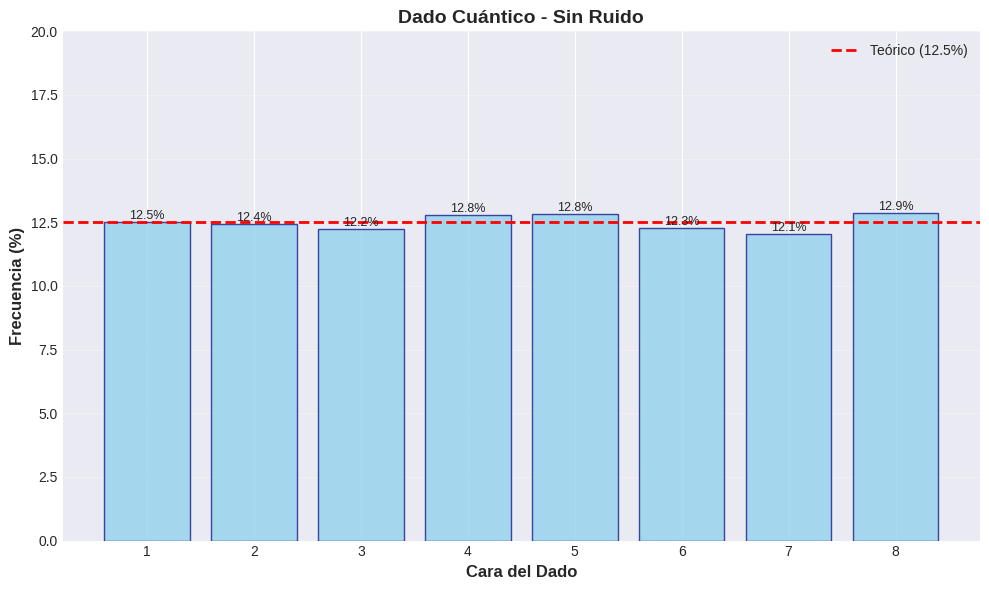


Frecuencias observadas:
Cara 1: 12.51%
Cara 2: 12.45%
Cara 3: 12.22%
Cara 4: 12.77%
Cara 5: 12.82%
Cara 6: 12.29%
Cara 7: 12.06%
Cara 8: 12.88%


In [40]:
def calcular_frecuencias(resultados):
    """
    Calcula las frecuencias de cada cara del dado.
    """
    contador = Counter(resultados)
    
    total = len(resultados)
    
    frecuencias = {}
    
    for i in range(1, 9):
        veces_que_salio = contador.get(i, 0)
        porcentaje = (veces_que_salio / total) * 100
        frecuencias[i] = porcentaje
    
    return frecuencias

def graficar_resultados_dado(resultados, titulo="Dado Cuántico", ax=None):

    frecuencias = calcular_frecuencias(resultados)
    caras = list(frecuencias.keys())
    porcentajes = list(frecuencias.values())
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Graficar barras
    bars = ax.bar(caras, porcentajes, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Línea del valor teórico (12.5%)
    ax.axhline(y=12.5, color='red', linestyle='--', linewidth=2, label='Teórico (12.5%)')
    
    # Configuración de ejes
    ax.set_xlabel('Cara del Dado', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frecuencia (%)', fontsize=12, fontweight='bold')
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.set_xticks(caras)
    ax.set_ylim([0, 20])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Añadir valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)
    
    return ax

# Graficar resultados sin ruido
graficar_resultados_dado(resultados_sin_ruido, "Dado Cuántico - Sin Ruido")
plt.tight_layout()
plt.show()

# Mostrar estadísticas
frecuencias_sin_ruido = calcular_frecuencias(resultados_sin_ruido)
print("\nFrecuencias observadas:")
for cara, freq in frecuencias_sin_ruido.items():
    print(f"Cara {cara}: {freq:.2f}%")

### Análisis de resultados sin ruido

Como podemos observar, los resultados se distribuyen de manera **casi perfectamente uniforme** alrededor del 12.5% teórico. Las pequeñas variaciones que vemos son simplemente normales.

## Implementación Con Ruido
En esta sección se simula el efecto del ruido de decoherencia aplicándolo directamente a los resultados generados por el circuito ideal.

### Modelo de Ruido T1

El ruido T1 provoca que un qubit en estado |1⟩ decaiga espontáneamente a |0⟩. La probabilidad de que esto ocurra depende del tiempo que dura la operación y del tiempo característico T1 del dispositivo.

La probabilidad de relajación se calcula como:

$p = 1 − exp(−gate_time / T1)$

En la simulación, cada vez que un qubit medido está en |1⟩, se le asigna una probabilidad p de cambiar a |0⟩. De este modo se modela la pérdida de energía típica de la decoherencia T1.


In [41]:
def aplicar_ruido_t1(resultados_bits, T1, gate_time=200e-9):
    """
    Aplica ruido T1 (relajación) a los resultados.

    Los qubits en |1⟩ tienen probabilidad de decaer a |0⟩.
    """
    p_relax = 1 - np.exp(-gate_time / T1)

    resultados_ruidosos = []

    for bits in resultados_bits:
        nuevo_bits = bits.copy()

        for i in range(len(bits)):
            if bits[i] == 1:
                if np.random.random() < p_relax:
                    nuevo_bits[i] = 0

        resultados_ruidosos.append(nuevo_bits)

    return resultados_ruidosos

def simular_dado_con_decoherencia(T1, T2=None, gate_time=200e-9, shots=10000):
    """
    Simula el dado cuántico con ruido de decoherencia.

    Por simplicidad, solo simulamos T1 (el efecto dominante).
    """
    qc = get_qc('3q-qvm')

    program = Program(
        Declare("ro", "BIT", 3),
        H(0),
        H(1),
        H(2),
        MEASURE(0, ("ro", 0)),
        MEASURE(1, ("ro", 1)),
        MEASURE(2, ("ro", 2)),
    ).wrap_in_numshots_loop(shots)

    executable = qc.compile(program)
    result = qc.run(executable)
    resultados_bits = result.get_register_map()['ro']

    # Aplicar ruido T1
    resultados_ruidosos = aplicar_ruido_t1(resultados_bits, T1, gate_time)

    # Convertir a números del dado
    resultados_dado = [binario_a_dado(bits) for bits in resultados_ruidosos]

    return resultados_dado

In [42]:
# 3 tipo de ruido
niveles_ruido = {
    'Ruido Bajo (QPU actual)': {'T1': 30e-6, 'T2': 15e-6},
    'Ruido Medio': {'T1': 10e-6, 'T2': 5e-6},
    'Ruido Alto': {'T1': 1e-6, 'T2': 0.5e-6}
}

In [43]:
resultados_decoherencia = {}

for nivel, params in niveles_ruido.items():
    print(f"{nivel}: T1={params['T1']*1e6:.1f}μs, T2={params['T2']*1e6:.1f}μs")
    resultados = simular_dado_con_decoherencia(params['T1'], params['T2'])
    resultados_decoherencia[nivel] = resultados

Ruido Bajo (QPU actual): T1=30.0μs, T2=15.0μs
Ruido Medio: T1=10.0μs, T2=5.0μs
Ruido Alto: T1=1.0μs, T2=0.5μs


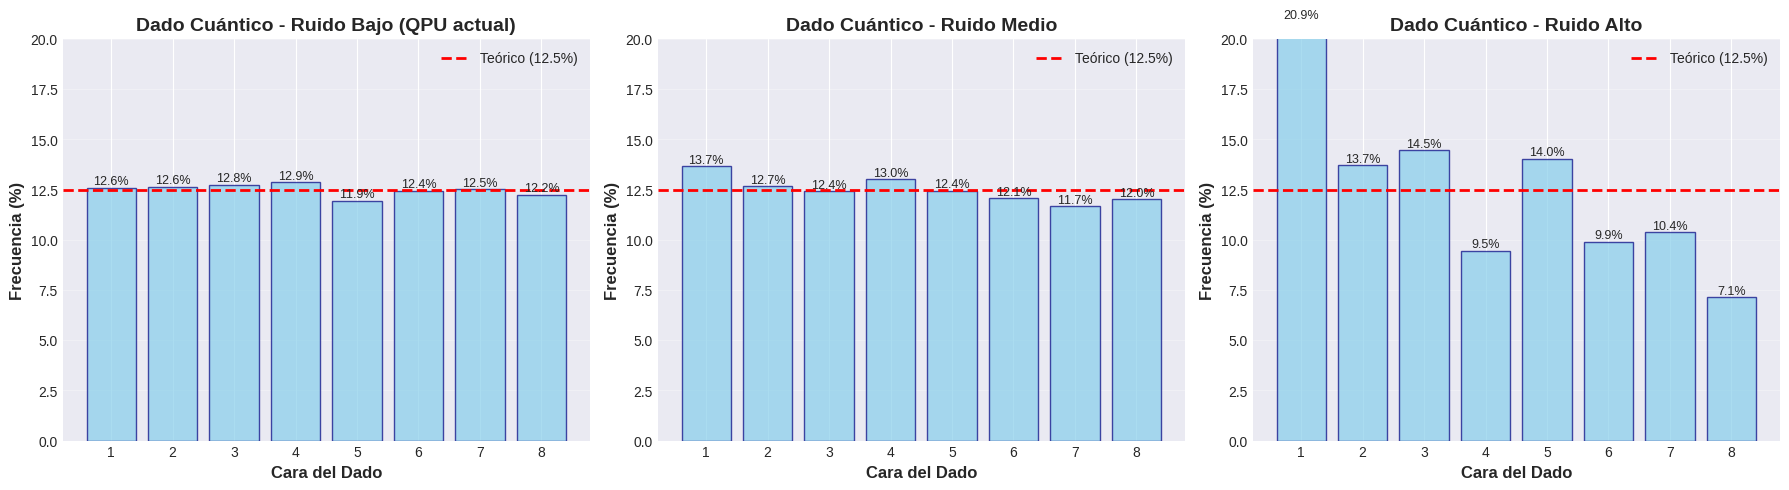


ANÁLISIS COMPARATIVO DE DECOHERENCIA

Ruido Bajo (QPU actual):
  Desviación estándar: 0.273%
  Máxima desviación del 12.5%: 0.550%

Ruido Medio:
  Desviación estándar: 0.586%
  Máxima desviación del 12.5%: 1.170%

Ruido Alto:
  Desviación estándar: 3.983%
  Máxima desviación del 12.5%: 8.380%



In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (nivel, resultados) in enumerate(resultados_decoherencia.items()):
    graficar_resultados_dado(resultados, f"Dado Cuántico - {nivel}", ax=axes[idx])

plt.tight_layout()
plt.show()

# Mostrar estadísticas detalladas
print("\n" + "="*60)
print("ANÁLISIS COMPARATIVO DE DECOHERENCIA")
print("="*60 + "\n")

for nivel, resultados in resultados_decoherencia.items():
    frecuencias = calcular_frecuencias(resultados)
    valores = list(frecuencias.values())
    desv_std = np.std(valores)
    max_desv = max([abs(v - 12.5) for v in valores])
    
    print(f"{nivel}:")
    print(f"  Desviación estándar: {desv_std:.3f}%")
    print(f"  Máxima desviación del 12.5%: {max_desv:.3f}%")
    print()

### Observaciones sobre el ruido de decoherencia

Los resultados evidencian el impacto del ruido T1 en el dado cuántico. Con niveles bajos de ruido, propios de muchas QPUs actuales, la distribución sigue siendo casi uniforme y solo aparecen pequeñas desviaciones. Cuando el ruido aumenta a valores intermedios, comienza a observarse un sesgo claro: las caras con mayor número de bits en |0⟩ adquieren más probabilidad, ya que la relajación T1 favorece la transición de |1⟩ a |0⟩. En niveles altos de ruido, la distribución se ve fuertemente distorsionada y el desplazamiento hacia resultados dominados por el estado |0⟩ se vuelve muy marcado. Este comportamiento refleja la naturaleza del ruido T1, que impulsa a los qubits hacia su estado fundamental.


## Implementación Con Ruido de Lectura

El ruido de lectura representa los errores que pueden producirse durante la medición de los qubits. Incluso si el estado cuántico antes de medir es correcto, la lectura puede asignar el valor equivocado. Para modelar este efecto se define, para cada qubit, una matriz de confusión basada en las probabilidades de medir correctamente cada estado.

### Matriz de confusión de lectura

- p(0|0): probabilidad de medir correctamente un estado |0⟩  
- p(1|1): probabilidad de medir correctamente un estado |1⟩  

A partir de ellas se obtienen las probabilidades de error:  
- p(1|0) = 1 − p(0|0): probabilidad de medir |1⟩ cuando el estado real es |0⟩  
- p(0|1) = 1 − p(1|1): probabilidad de medir |0⟩ cuando el estado real es |1⟩  

En dispositivos cuánticos reales la fidelidad de lectura suele situarse entre el 95 % y el 99 %, por lo que este tipo de error puede tener un efecto apreciable en distribuciones sensibles como la del dado cuántico.


In [45]:
def aplicar_ruido_lectura(resultados_bits, p00=0.95, p11=0.95):

    resultados_ruidosos = []

    for bits in resultados_bits:
        nuevo_bits = bits.copy()

        for i in range(len(bits)):
            if bits[i] == 0:
                if np.random.random() > p00:
                    nuevo_bits[i] = 1
            else:
                if np.random.random() > p11:
                    nuevo_bits[i] = 0

        resultados_ruidosos.append(nuevo_bits)

    return resultados_ruidosos

def simular_dado_con_ruido_lectura(p00, p11, shots=10000):
    """
    Simula el dado cuántico con ruido de lectura.
    """
    qc = get_qc('3q-qvm')

    program = Program(
        Declare("ro", "BIT", 3),
        H(0),
        H(1),
        H(2),
        MEASURE(0, ("ro", 0)),
        MEASURE(1, ("ro", 1)),
        MEASURE(2, ("ro", 2)),
    ).wrap_in_numshots_loop(shots)

    executable = qc.compile(program)
    result = qc.run(executable)
    resultados_bits = result.get_register_map()['ro']

    resultados_ruidosos = aplicar_ruido_lectura(resultados_bits, p00, p11)
    resultados_dado = [binario_a_dado(bits) for bits in resultados_ruidosos]

    return resultados_dado

In [46]:
# Definir tres niveles de fidelidad de lectura
niveles_lectura = {
    'Alta Fidelidad (99%)': {'p00': 0.99, 'p11': 0.99},
    'Media Fidelidad (95%)': {'p00': 0.95, 'p11': 0.95},
    'Baja Fidelidad (85%)': {'p00': 0.85, 'p11': 0.85}
}

In [47]:
resultados_lectura = {}

for nivel, params in niveles_lectura.items():
    print(f"{nivel}: p(0|0)={params['p00']}, p(1|1)={params['p11']}")
    resultados = simular_dado_con_ruido_lectura(params['p00'], params['p11'])
    resultados_lectura[nivel] = resultados

Alta Fidelidad (99%): p(0|0)=0.99, p(1|1)=0.99
Media Fidelidad (95%): p(0|0)=0.95, p(1|1)=0.95
Baja Fidelidad (85%): p(0|0)=0.85, p(1|1)=0.85


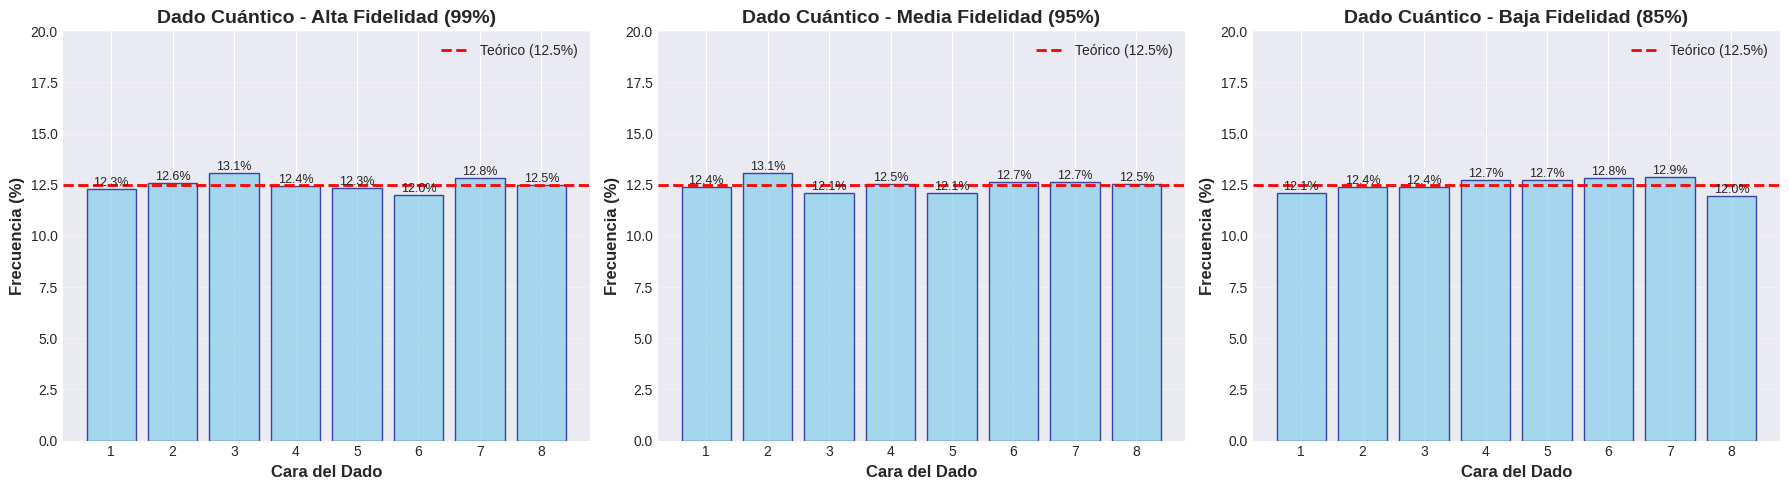

ANÁLISIS COMPARATIVO DE RUIDO DE LECTURA
Alta Fidelidad (99%):
  Desviación estándar: 0.301%
  Máxima desviación del 12.5%: 0.560%

Media Fidelidad (95%):
  Desviación estándar: 0.298%
  Máxima desviación del 12.5%: 0.570%

Baja Fidelidad (85%):
  Desviación estándar: 0.317%
  Máxima desviación del 12.5%: 0.530%



In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (nivel, resultados) in enumerate(resultados_lectura.items()):
    graficar_resultados_dado(resultados, f"Dado Cuántico - {nivel}", ax=axes[idx])

plt.tight_layout()
plt.show()

print("ANÁLISIS COMPARATIVO DE RUIDO DE LECTURA")


for nivel, resultados in resultados_lectura.items():
    frecuencias = calcular_frecuencias(resultados)
    valores = list(frecuencias.values())
    desv_std = np.std(valores)
    max_desv = max([abs(v - 12.5) for v in valores])
    
    print(f"{nivel}:")
    print(f"  Desviación estándar: {desv_std:.3f}%")
    print(f"  Máxima desviación del 12.5%: {max_desv:.3f}%")
    print()

### Observaciones sobre el ruido de lectura

El ruido de lectura se comporta de forma distinta al ruido de decoherencia. Con una fidelidad alta (99%), su efecto es mínimo y la distribución permanece prácticamente uniforme. Cuando la fidelidad desciende a valores medios (95%), comienzan a aparecer desviaciones apreciables aunque sin un patrón claro, a diferencia del sesgo hacia estados con más ceros que provoca el ruido T1. Con fidelidades bajas (85%), la distribución se degrada de forma notable y las diferencias entre las frecuencias de aparición de cada cara se vuelven grandes. Este tipo de ruido no introduce un sesgo sistemático hacia determinados resultados, sino que añade errores esencialmente aleatorios, aunque si las probabilidades de lectura p00 y p11 no son iguales pueden aparecer sesgos asimétricos.


## Conclusiones

El dado cuántico de 8 caras sirve como ejemplo para entender el impacto del ruido en sistemas cuánticos.

- **Distribución ideal**: Sin ruido, cada cara del dado aparece con la misma probabilidad, reflejando la superposición perfecta de los qubits.
- **Ruido de decoherencia (T1/T2)**: Introduce un sesgo hacia el estado |0⟩, haciendo que las caras asociadas a más ceros sean más frecuentes.
- **Ruido de lectura**: Afecta la medición y degrada la uniformidad, generando errores aleatorios que alteran los resultados.
- **Combinación de ruidos**: La presencia simultánea de decoherencia y errores de lectura degrada completamente la uniformidad del dado.
- **Retos**:
  - La información cuántica es extremadamente frágil.
  - Se requiere desarrollo de códigos de corrección de errores cuánticos.
  - Son necesarias técnicas de mitigación de errores.
  - Mejorar la coherencia del hardware es fundamental.